### Bibliotecas

In [8]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import os

### Importando Datos

In [28]:
path = '/home/faber/EK_AutoNOMOS_Sim/src/autonomos_gazebo_simulation/scripts'
passingDir = path + '/dataTRAIN'
passingImagesDir = passingDir + '/dataset_passing'
#passingImages = !ls -1 '{passingImagesDir}'
passingImages = os.listdir(passingImagesDir)

print('Imágenes de ciudad: ', len(passingImages))

Imágenes de ciudad:  16836


In [26]:
passingImages

TypeError: must use keyword argument for key function

In [34]:
lidarCSV = passingDir + '/lidar.csv'
outputsCSV = passingDir + '/outputs.csv'

outputs = pd.read_csv(outputsCSV, names=['angle', 'speed'], sep='\t')
lidar = pd.read_csv(lidarCSV, sep='\t', header=None)
lidar = lidar.iloc[: , :-1]

print("Diferencia entre tamaño de los DF y numero de imgs: ")
print((len(outputs) - len(passingImages)))
print((len(lidar) - len(passingImages)))

data = pd.concat([outputs, lidar], axis=1, join='inner')
data['img'] = sorted(passingImages, key=lambda x:int(x.replace('_camara.png', '')))

cols = data.columns.tolist()
cols = cols[-1:] + cols[:-1]
data = data[cols]

Diferencia entre tamaño de los DF y numero de imgs: 
0
0


In [36]:
#lidar.head()
#outputs.head()
data.head()

,img,angle,speed,0,1,2,3,4,5,6,...,350,351,352,353,354,355,356,357,358,359
0,1_camara.png,103.0,-600,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
1,2_camara.png,103.0,-600,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
2,3_camara.png,103.0,-600,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
3,4_camara.png,106.0,-600,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
4,5_camara.png,106.0,-600,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0


### Visualizando datos

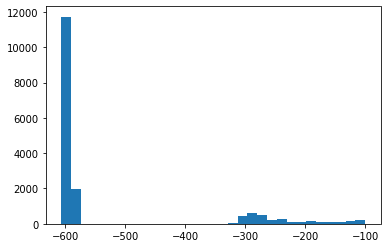

In [37]:
plt.hist(data['speed'], bins = 31)
plt.show()

In [ ]:
def binningData(nbins, samplesPerBin, data):
  hist, bins = np.histogram(data['speed'].to_numpy(), nbins)
  removeIndexList = []
  for j in range(nbins):
    binDataList = []
    for i in range(len(data['speed'])):
      if data['speed'][i] >= bins[j] and data['speed'][i] <= bins[j+1]:
        binDataList.append(i)
    binDataList = shuffle(binDataList)
    binDataList = binDataList[samplesPerBin:]
    removeIndexList.extend(binDataList)
  print('Removed images: ', len(removeIndexList))
  data.drop(data.index[removeIndexList], inplace=True)
  print('Remaining images: ', len(data))

In [ ]:
binningData(31, 2000, data)

Removed images:  9727
Remaining images:  7109


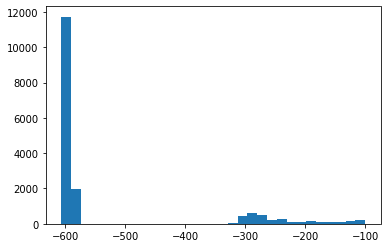

In [38]:
plt.hist(data['speed'], bins = 31)
plt.show()

### Input pipeline

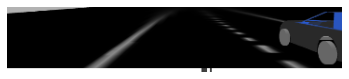

out:  (-0.033333333333333326, 0.75875)


In [39]:
def crop(inimg):
  #image = inimg[270:405, :, :]
  image = inimg[220:370, :, :]
  image = tf.image.resize(image, [66, 360])
  #image = tf.image.rgb_to_yuv(image) # Lo he probado con YUV, pero no he visto mejoras perceptibles
  return image

def normalize(image):
  #inImg = (image/127.5) - 1  # normaliza de 0 a 255 -> -1 a 1
  inImg = image/255           # normaliza de 0 a 255 -> 0 a 1
  return inImg

def loadPista(filename, angle, speed, lidar, dir, flip = False, augment = False):
  inImg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(dir + '/' + filename)), tf.float32)[...,:3]
  #inImg = tf.image.adjust_contrast(inImg, 2)
  #inImg = tf.image.adjust_brightness(inImg, delta = 0.1) # udacity simulator

  # aumentación de datos aleatoria
  if augment:
    if np.random.rand() < 0.5:
      inImg = tf.image.random_hue(inImg, .2)
    if np.random.rand() < 0.5:
      inImg = tf.image.random_saturation(inImg, 1, 3)
    if np.random.rand() < 0.5:
      inImg = tf.image.random_brightness(inImg, 0.5)
    if np.random.rand() < 0.5:
      inImg = tf.image.random_contrast(inImg, 0.4, 1)

  inImg = normalize(inImg)
  inImg = crop(inImg)
  
  # se invierte la imágen horizontalmente y si se hace, se invirte el ángulo
  if flip:
    inImg = tf.image.flip_left_right(inImg)
    angle = angle * -1
    lidar = lidar[::-1]

  # el último paso de la aumentación de datos es un corte aleatorio al que después
  # se le cambia el tamaño para que pueda ser procesado por la red
  if augment:
    if np.random.rand() < 0.5:
      inImg = tf.image.random_crop(value=inImg, size=(50, 150, 3))
      #inImg = tf.image.resize(inImg, [66, 200])
      inImg = tf.image.resize(inImg, [66, 360])

  angle = ((angle/180)*2)-1
  speed = -speed/800
  outputs = (angle, speed)

  # lidar as img
  lidar = lidar[::-1]
  #lidar.astype('float32')
  lidar = tf.roll(lidar, 180, axis = 0)
  lidar /= 3
  lidarImg = [
              lidar,
              lidar,
              lidar,
              lidar
              ]
  lidarImg = [lidarImg,lidarImg,lidarImg]
  
  lidarImg = tf.transpose(lidarImg,[1, 2, 0])
  inImg = tf.concat([inImg, lidarImg], 0)

  return inImg, outputs



# Prueba función de load
row = data.iloc[3980] #de 3900 a 4030 hay un rebase después del binning a 800 en speed en el primer dataset
lidarVector = row[3:363].to_numpy().astype('float32')
image, angle = loadPista(row['img'], row['angle'], row['speed'], lidarVector, passingImagesDir, flip=False, augment=False)
#plt.title('Imagen de prueba: ' + urlsPista2_manual[0])
#plt.imshow((image + 1) / 2)    # Si se normalizó de -1 a 1
plt.imshow(image)               # Si se normalizó de 0 a 1
plt.axis('off')
plt.show()
print('out: ', angle)
#plt.imshow(tf.cast(tf.image.decode_jpeg(tf.io.read_file(passingImagesDir + '/' + row['img'])), tf.uint8)[...,:3])
#print(np.shape(image))

In [47]:
cols = data.columns.tolist()
cols = cols[3:363]

dataset_p1 = tf.data.Dataset.from_tensor_slices((
    data['img'].to_list(), 
    np.squeeze(data['angle'].to_numpy()), 
    np.squeeze(data['speed'].to_numpy()), 
    np.squeeze(data[cols].to_numpy().astype('float32'))
    ))
dataset_p1 = dataset_p1.map(lambda img, ang, spd, radar: loadPista(img, ang, spd, radar, passingImagesDir, flip=False, augment=False))

dataset_p2 = tf.data.Dataset.from_tensor_slices((
    data['img'].to_list(), 
    np.squeeze(data['angle'].to_numpy()), 
    np.squeeze(data['speed'].to_numpy()), 
    np.squeeze(data[cols].to_numpy().astype('float32'))
    ))
dataset_p2 = dataset_p2.map(lambda img, ang, spd, radar: loadPista(img, ang, spd, radar, passingImagesDir, flip=False, augment=True))

fullDataset = dataset_p1.concatenate(dataset_p2)
fullDataset = fullDataset.batch(128)
DATASET_SIZE = fullDataset.cardinality().numpy()
#fullDataset = fullDataset.shuffle(DATASET_SIZE)

train_size = int(1 * DATASET_SIZE)
val_size = int(0 * DATASET_SIZE)

print("Tamaño del dataset en lotes (batches): ", DATASET_SIZE)
print("Tamaño del dataset de entrenamiento en lotes (batches): ", train_size)
print("Tamaño del dataset de validacipon en lotes (batches): ", val_size)

train_dataset = fullDataset.take(train_size)
val_dataset = fullDataset.skip(train_size)

Tamaño del dataset en lotes (batches):  264
Tamaño del dataset de entrenamiento en lotes (batches):  264
Tamaño del dataset de validacipon en lotes (batches):  0


### RED 1 (OSCAR)

In [42]:
# Red
from tensorflow.keras import *
from tensorflow.keras.layers import *

initializer = tf.random_normal_initializer(0., 0.04)

model = models.Sequential()

model.add(tf.keras.layers.Input(shape = [70, 360, 3]))

model.add(layers.Conv2D(24, (5, 5), (2,2) , activation='elu',padding='SAME', kernel_initializer = initializer))
#model.add(tf.keras.layers.BatchNormalization())
#model.add(tf.keras.layers.Dropout(0.3))

model.add(layers.Conv2D(36, (5, 5), (2,2), activation='elu', padding='SAME', kernel_initializer = initializer))
#model.add(tf.keras.layers.BatchNormalization())
#model.add(tf.keras.layers.Dropout(0.3))

model.add(layers.Conv2D(48, (5, 5), (2,2), activation='elu', padding='SAME', kernel_initializer = initializer))
#model.add(tf.keras.layers.BatchNormalization())
#model.add(tf.keras.layers.Dropout(0.3))

model.add(layers.Conv2D(64, (3, 3), activation='elu', padding='SAME', kernel_initializer = initializer))
#model.add(tf.keras.layers.BatchNormalization())
#model.add(tf.keras.layers.Dropout(0.3))

model.add(layers.Conv2D(64, (3, 3), activation='elu', padding='SAME', kernel_initializer = initializer))
#model.add(tf.keras.layers.BatchNormalization())
#model.add(tf.keras.layers.Dropout(0.3))

#model.add(layers.GlobalMaxPool2D())

model.add(Flatten())

model.add(Dense(100, activation='sigmoid'))
#model.add(tf.keras.layers.Dropout(0.2))
#model.add(tf.keras.layers.BatchNormalization())

model.add(Dense(50, activation='sigmoid'))
#model.add(tf.keras.layers.Dropout(0.2))
#model.add(tf.keras.layers.BatchNormalization())

#model.add(Dense(25, activation='sigmoid'))
#model.add(tf.keras.layers.Dropout(0.2))
#model.add(tf.keras.layers.BatchNormalization())

model.add(Dense(10, activation='sigmoid'))
#model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(2))

#opt = tf.keras.optimizers.Adam(learning_rate=0.3)
opt = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)

model.compile(
    #loss='mean_absolute_error',
    loss = 'mean_squared_error',
    metrics = 'mean_absolute_error',
    optimizer= opt
    )

print(model.summary())
#utils.plot_model(model)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 35, 180, 24)       1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 90, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 45, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 45, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 9, 45, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 25920)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               2

### Train

In [ ]:
history = model.fit(
    train_dataset,
    epochs = 10,
    #validation_data = val_dataset
    )

In [49]:
#import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open(path + '/models/RevaseV0.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp7_6osek3/assets


In [50]:
# Guarda el modelo
model.save(path +'/models/RevaseV0.h5')

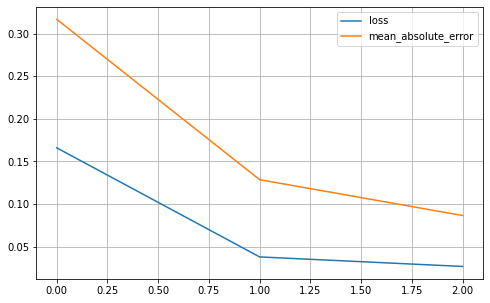

In [ ]:
pd.DataFrame(history.history).plot(figsize = (8, 5))
plt.grid(True)
#plt.ylim((0,1))
plt.show()

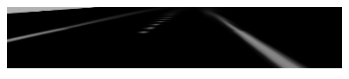

predict:  -0.022657957 -0.027160406
Truth:  [-0.04444444] [0.75]


In [ ]:
for testImage, angle in train_dataset.take(1):
  pass

predict = model(testImage, training = False)

#plt.imshow((testImage[0, ...] + 1) / 2)   # Si se normalizó de -1 a 1
plt.imshow(testImage[0, ...])              # Si se normalizó de 0 a 1
plt.axis('off')
plt.show()
print('predict: ', predict.numpy()[0][0], predict.numpy()[0][1])
print('Truth: ', angle[0].numpy(), angle[1].numpy())